In [2]:
#Common Library
import numpy as np
import pandas as pd
from __future__ import division
from datetime import datetime, timedelta
from dateutil import parser
import time
#Sklearn
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#Matplotlib
import matplotlib.pyplot as plt
# TPOT
from tpot import TPOTRegressor
# NeuPy
from neupy import algorithms, layers, environment

In [3]:
def DataPrepare(df):
    data = df.drop(df.columns[[15,16]],axis=1)
    #target PT08.S1, PT08.S2, PT08.S3, PT08.S4, PT08.S5
    col_target = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
    target = data[col_target]

    data.drop(['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)'], axis=1, inplace=True)

    data['Date'] = df.Date.astype(str).str.cat(df.Time.astype(str), sep=' ')
    data = data.drop(['Time'], axis=1)
    data = data.rename(columns={'Date': 'DateTime'})
    data['DateTime'] = pd.to_datetime(data['DateTime'])
    return data, target

def totimestamp(dt, epoch=datetime(1970,1,1)):
    td = dt - epoch
    # return td.total_seconds()
    return (td.microseconds + (td.seconds + td.days * 86400) * 10**6) / 10**6 

def ConvertDateTime(source):
    X = source.values
    for i in xrange(0, len(source['DateTime'])):
        #del X[i,:]
        tmp = parser.parse(str(source['DateTime'][i]))
        #print str(int(totimestamp(tmp)))
        #timestamp.append(str(int(totimestamp(tmp))))
        X[i,0] = float(totimestamp(tmp))
        X[i,1] = X[i,1].replace(',', '.')
        X[i,1] = float(X[i,1])
        X[i,3] = X[i,3].replace(',', '.')
        X[i,3] = float(X[i,3])
        X[i,6] = X[i,6].replace(',', '.')
        X[i,6] = float(X[i,6])
        X[i,7] = X[i,7].replace(',', '.')
        X[i,7] = float(X[i,7])
        X[i,8] = X[i,8].replace(',', '.')
        X[i,8] = float(X[i,8])
    return X

def Clean(X, Y):
    mx = []
    my = []
    
    for i in xrange(0, len(X[0])):
        mx.append(np.mean(X[:,i]))
        
    for i in xrange(0, len(Y[0])):
        my.append(np.mean(Y[:,i]))
    
    for i in xrange(0, len(X)):
        for j in xrange(1, len(X[0])):
            if X[i,j] == -200.0:
                X[i,j] = mx[j]
                #print(str(i) + str(j))
    for i in xrange(0, len(Y)):
        for j in xrange(1, len(Y[0])):
            if Y[i,j] == -200.0:
                Y[i,j] = my[j]
                #print(str(i) + " " + str(j))
    return X, Y

def DataPreparePipeline(source, showData=False):
    data, target = DataPrepare(source);
    X = ConvertDateTime(data)
    X, Y = Clean(X, target.values)
    return X, Y

In [4]:
def FeatureSelectionModel(x, y):
    max_depth = 30
    #regr_multirf = MultiOutputRegressor(RandomForestRegressor(max_depth=max_depth, random_state=0))
    #regr_multirf.fit(x, y)
    regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)
    regr_rf.fit(x, y)
    model = SelectFromModel(regr_rf, prefit=True)
    return model

def FeatureSelectionTransform(fs_model, x):
    x_reduced = fs_model.transform(x)
    print(x_reduced.shape)
    return x_reduced

def FeatureSelectionInverse(fs_model, x_reduced):
    x = fs_model.inverse_transform(x_reduced)
    print(x.shape)
    return x

In [5]:
def BuildDataScale(X, Y):
    xs = preprocessing.MinMaxScaler()
    ys = preprocessing.MinMaxScaler()
    xs.fit(X)
    ys.fit(Y)
    return xs, ys

def DataScaleTransform(scale_model, data):
    data_scaled = scale_model.transform(data)
    return data_scaled

def DataScaleInverse(scale_model, data_scaled):
    data = scale_model.inverse_transform(data_scaled)
    return data

In [6]:
def ANNForecastBuild(layer, step):
    return algorithms.ConjugateGradient(
        connection=layer,
        search_method='golden',
        show_epoch=25,
        verbose=True,
        step=step,
        addons=[algorithms.LinearSearch],
    )

def TrainANN(model, x, y, e = 1000):
    environment.reproducible()
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)
    model.train(x_train, y_train, x_test, y_test, epochs=e)
    return x_train, x_test, y_train, y_test


In [7]:
def Evaluation(y_true, y_pred):
    print("R2")
    print(r2_score(y_true, y_pred))
    print("RMSE")
    print(np.sqrt(mean_squared_error(y_true, y_pred)))
    #print(mean_squared_error(y_true, y_pred))
    print("RMSE per output")
    print(np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values')))
    x = range(0, len(y_pred))
    for i in range(0, len(y_pred[0])):   
        plt.figure(figsize=(20,10))
        plt.scatter(x, y_pred[:,i], c='r', marker='^')
        plt.scatter(x, y_true[:,i], c='b', marker='o')
        plt.show()


In [8]:
df = pd.read_csv('AirQualityUCI/AirQualityUCI.csv', delimiter=';')
df = df[0:9357]
X, Y = DataPreparePipeline(df)


(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.61 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |    0.021174 |    0.021378 |      173 ms |
|          25 |   0.0047808 |   0.0048841 |      149 ms |
|          50 |   0.0043807 |   0.0044557 |      164 ms |
|          75 |   0.0

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


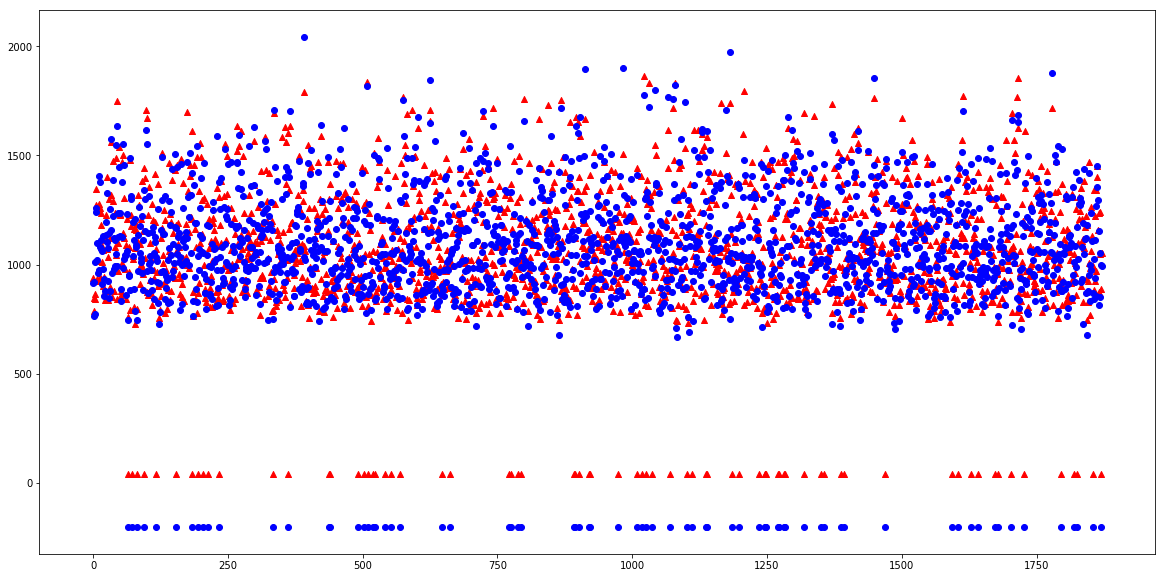

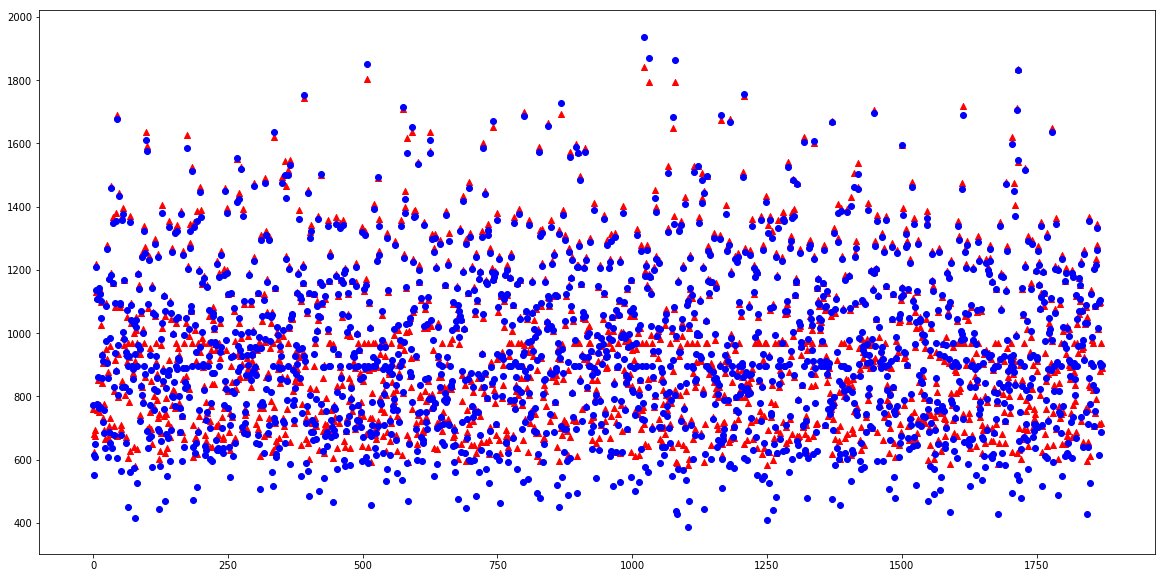

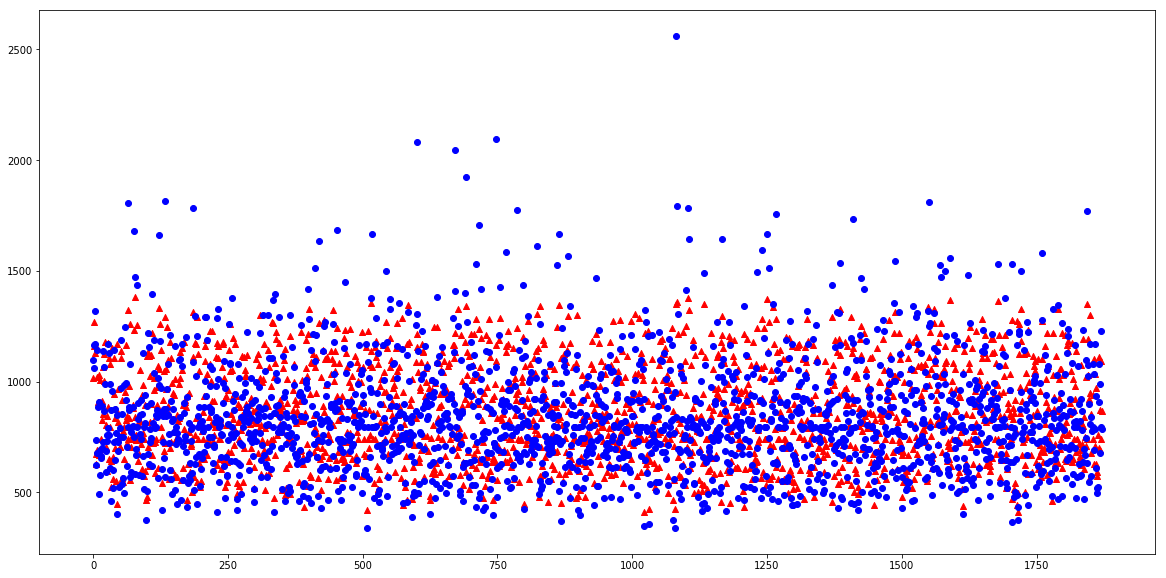

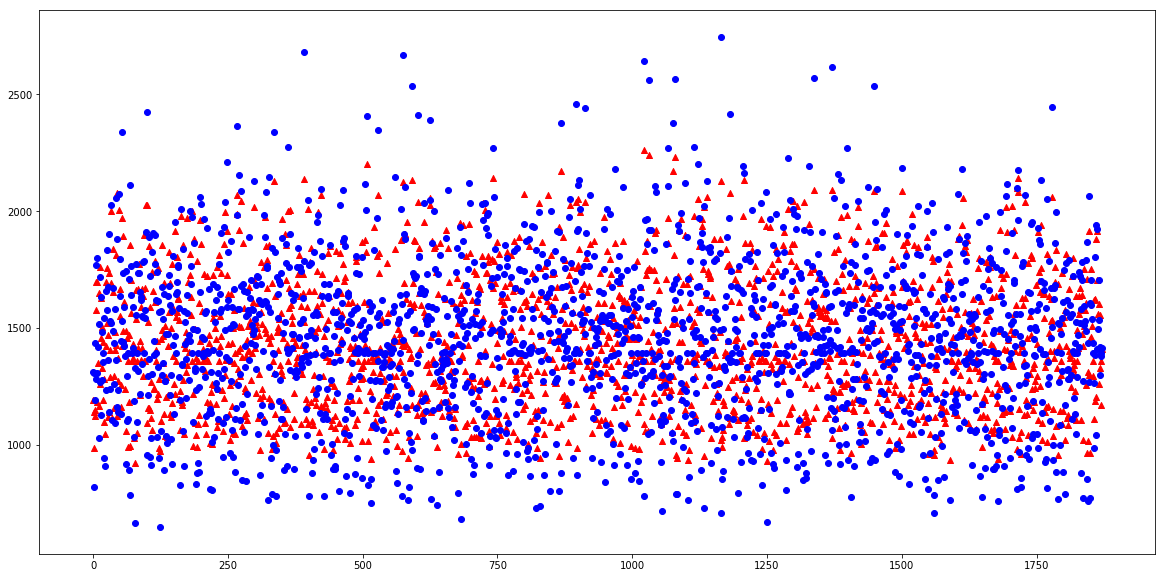

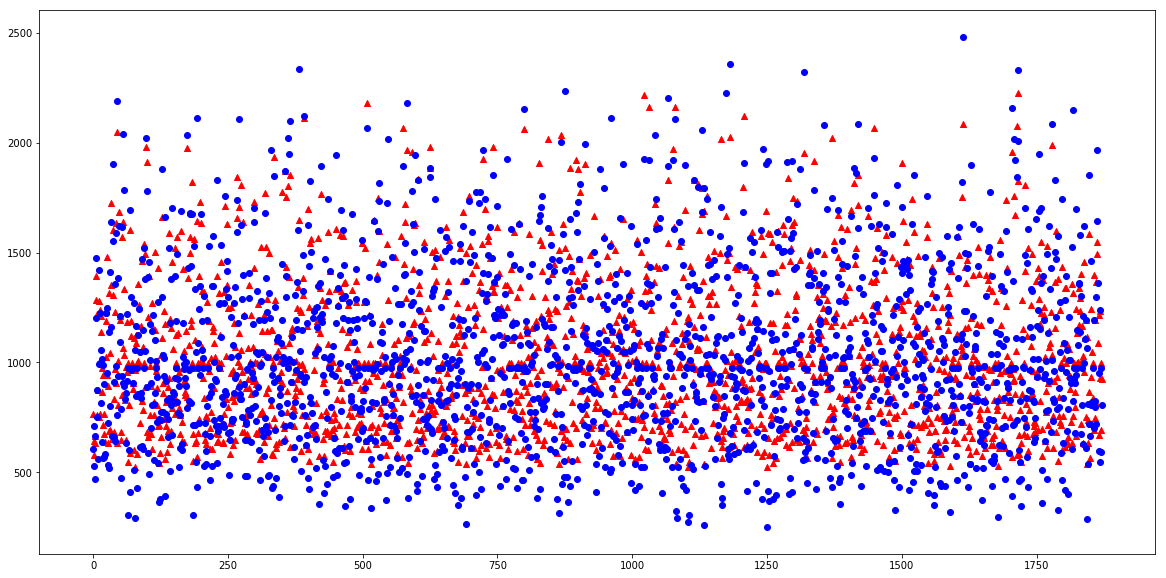

In [11]:
#test pipeline 1 - Feature Selection -> ANN
#pca = MyPCA(X)
fs_model = FeatureSelectionModel(X, Y)
X_reduced = FeatureSelectionTransform(fs_model, X)
xs, ys = BuildDataScale(X_reduced, Y)
x_scale = DataScaleTransform(xs, X_reduced)
y_scale = DataScaleTransform(ys, Y)
layer = [
            layers.Input(len(X_reduced[0])),
            layers.Sigmoid(15),
            layers.Sigmoid(5),
        ]
net = ANNForecastBuild(layer, 0.1)
start_time = time.time()
x_train, x_test, y_train, y_test = TrainANN(net, x_scale, y_scale, e=100)
elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

#evaluation
y_pred = net.predict(x_test)
y_pred = DataScaleInverse(ys, y_pred)
y_true = DataScaleInverse(ys, y_test)
Evaluation(y_true, y_pred)


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)



Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 5.51 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |    0.021966 |    0.022155 |      263 ms |
|          25 |   0.0062432 |   0.0064616 |      139 ms |
|          50 |   0.0044754 |    0.004584 |      142 ms |
|          75 |   0.0034902 |  

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


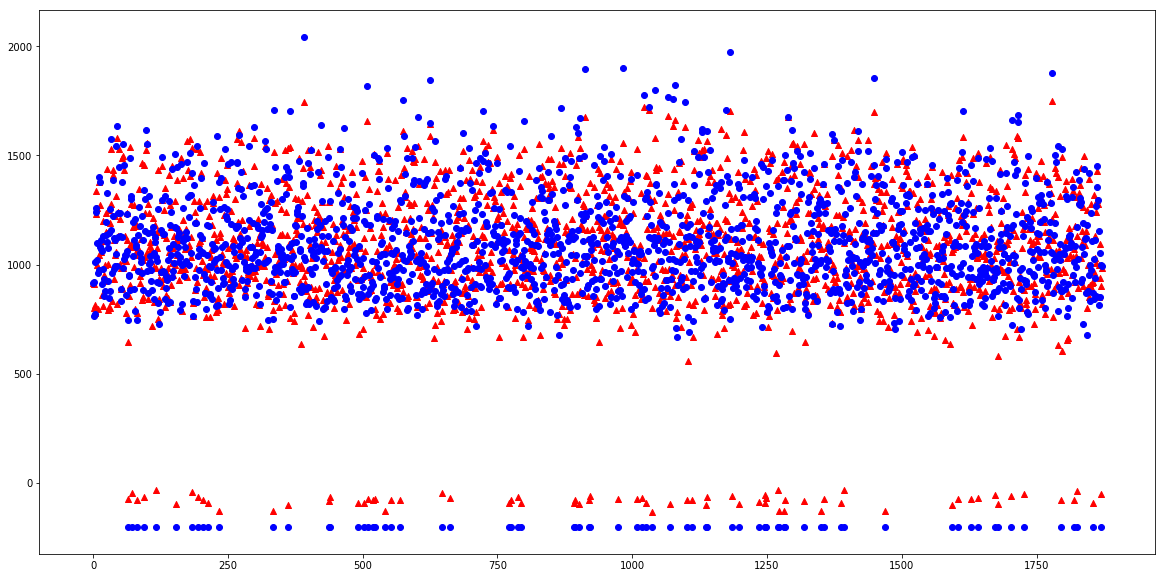

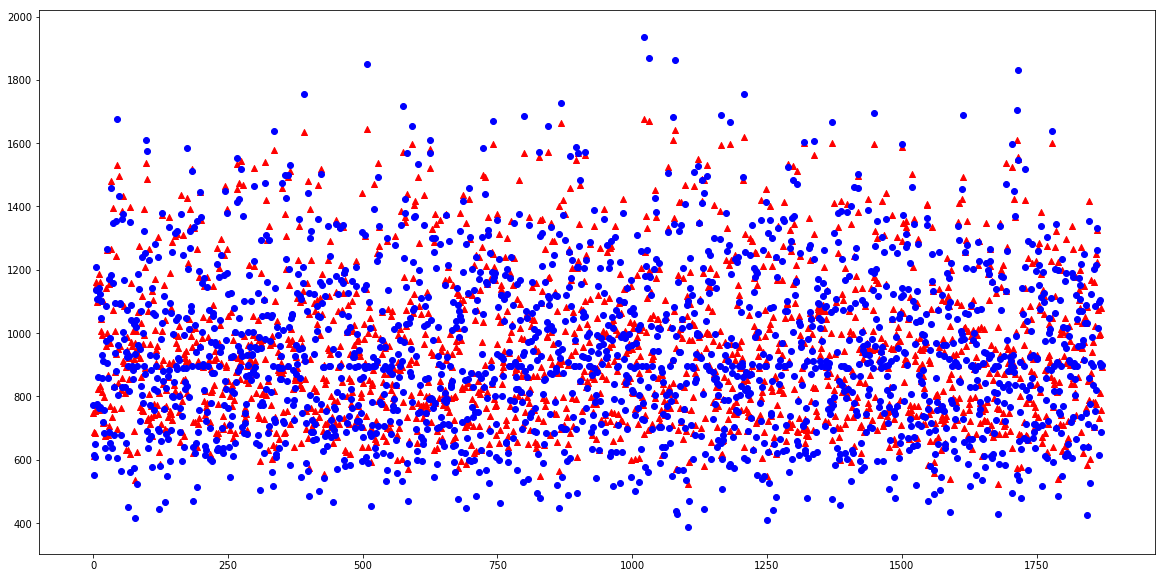

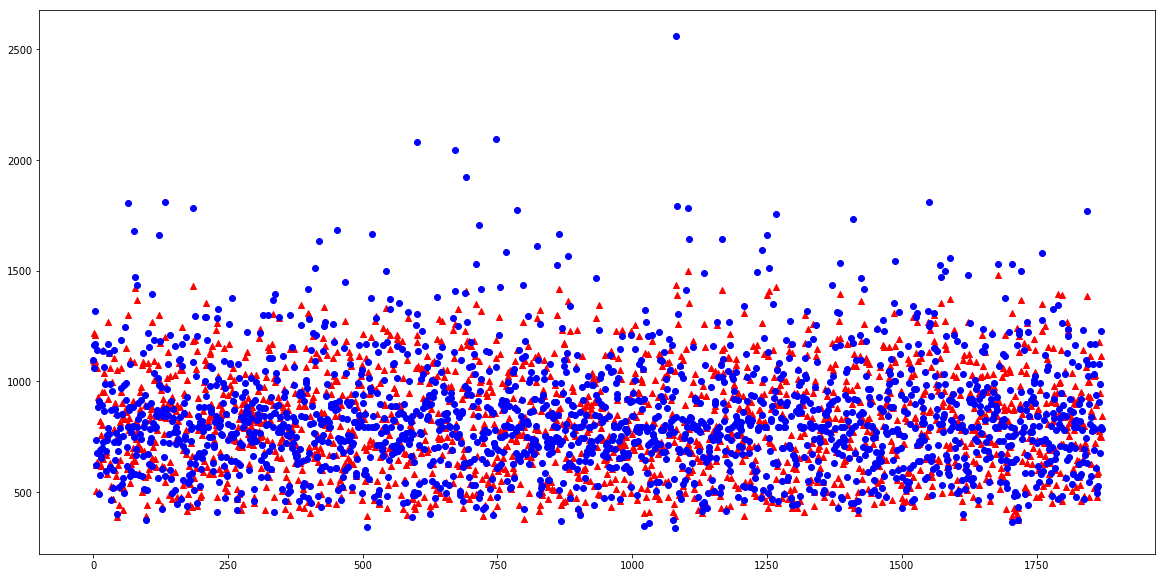

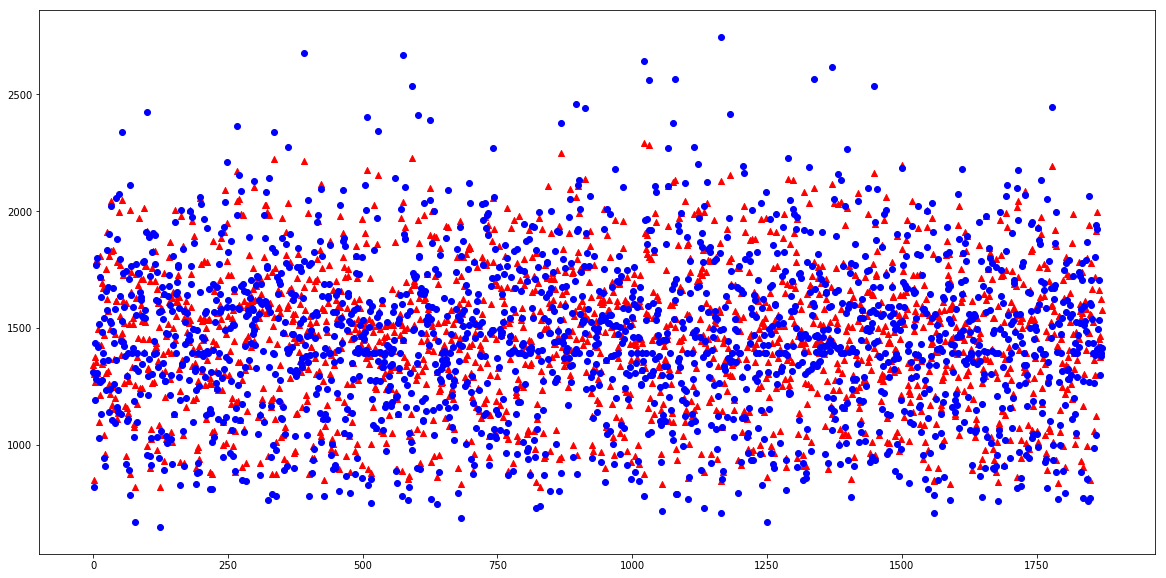

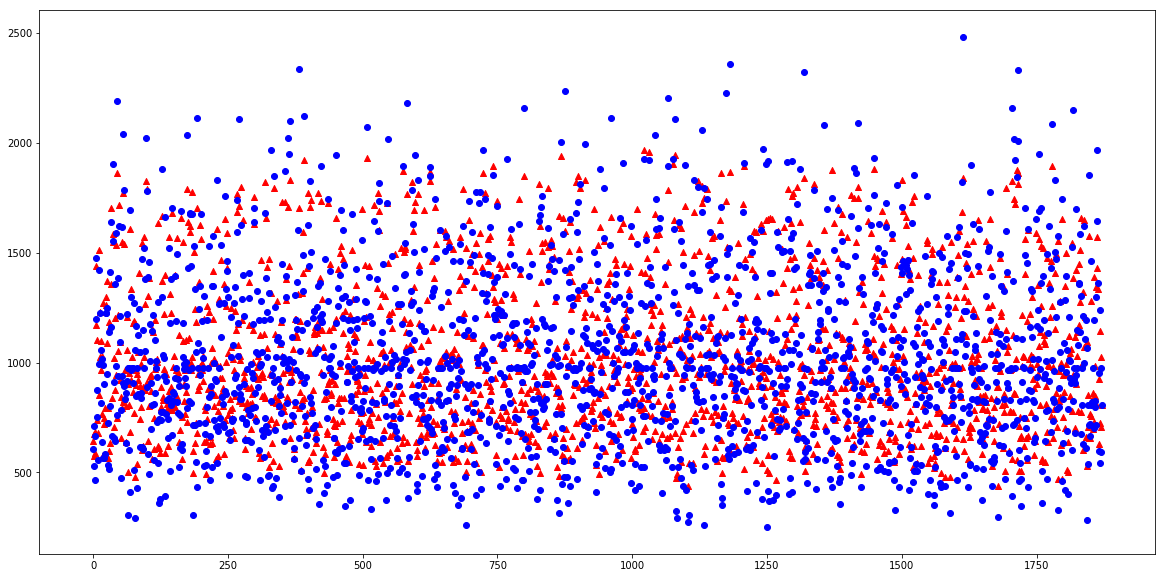

In [9]:
#test pipeline 2 - ANN
xs, ys = BuildDataScale(X, Y)
x_scale = DataScaleTransform(xs, X)
y_scale = DataScaleTransform(ys, Y)
layer = [
            layers.Input(len(X[0])),
            layers.Sigmoid(15),
            layers.Sigmoid(5),
        ]
net = ANNForecastBuild(layer, 0.1)
start_time = time.time()
x_train, x_test, y_train, y_test = TrainANN(net, x_scale, y_scale, e=100)
elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

#evaluation
y_pred = net.predict(x_test)
y_pred = DataScaleInverse(ys, y_pred)
y_true = DataScaleInverse(ys, y_test)
Evaluation(y_true, y_pred)

In [9]:
import math

from optimal import GenAlg
from optimal import Problem
from optimal import helpers

err_threshold = 140


def decode_param(binary):
    learning_rate = helpers.binary_to_float(binary[0:16], 0.4, 1.0)
    neuron = helpers.binary_to_int(binary[16:32], 10, 15)
    return learning_rate, neuron

def ann_fs_fitness(solution):
    learning_rate, neuron = solution
    
    #
    fs_model = FeatureSelectionModel(X, Y)
    X_reduced = FeatureSelectionTransform(fs_model, X)
    xs, ys = BuildDataScale(X_reduced, Y)
    x_scale = DataScaleTransform(xs, X_reduced)
    y_scale = DataScaleTransform(ys, Y)
    layer = [
                layers.Input(len(X_reduced[0])),
                layers.Sigmoid(neuron),
                layers.Sigmoid(5),
            ]
    net = ANNForecastBuild(layer, learning_rate)
    start_time = time.time()
    x_train, x_test, y_train, y_test = TrainANN(net, x_scale, y_scale, e=100)
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

    #evaluation
    y_pred = net.predict(x_test)
    y_pred = DataScaleInverse(ys, y_pred)
    y_true = DataScaleInverse(ys, y_test)
    #Evaluation(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    m_rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('m_rmse : ' + str(m_rmse));
    print('r2 : ' + str(r2));
    print('rmse : ' + str(rmse));
    print('lr : ' + str(learning_rate) + ', hidden neuron : ' + str(neuron));
    output = rmse

    finished = output <= err_threshold
    #finished = output <= 0.01
    fitness = 1 / output
    print(finished)
    print(fitness)
    return fitness, finished
    
def ann_fitness(solution):
    learning_rate, neuron = solution
    
    #
    xs, ys = BuildDataScale(X, Y)
    x_scale = DataScaleTransform(xs, X)
    y_scale = DataScaleTransform(ys, Y)
    layer = [
                layers.Input(len(X[0])),
                layers.Sigmoid(neuron),
                layers.Sigmoid(5),
            ]
    net = ANNForecastBuild(layer, learning_rate)
    start_time = time.time()
    x_train, x_test, y_train, y_test = TrainANN(net, x_scale, y_scale, e=100)
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

    #evaluation
    y_pred = net.predict(x_test)
    y_pred = DataScaleInverse(ys, y_pred)
    y_true = DataScaleInverse(ys, y_test)
    #Evaluation(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    m_rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('m_rmse : ' + str(m_rmse));
    print('r2 : ' + str(r2));
    print('rmse : ' + str(rmse));
    print('lr : ' + str(learning_rate) + ', hidden neuron : ' + str(neuron));
    output = rmse

    finished = output <= err_threshold
    #finished = output <= 0.01
    fitness = 1 / output
    print(finished)
    print(fitness)
    return fitness, finished


In [10]:
#Pipeine 3 - FS->ANN->GA
ann_ml = Problem(ann_fs_fitness, decode_function=decode_param)
my_genalg = GenAlg(32, mutation_chance=0.1, crossover_chance=0.8)
start_time = time.time()
best_solution = my_genalg.optimize(ann_ml, max_iterations=15, n_processes=1)
elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

print best_solution

/usr/local/lib/python2.7/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.986596475166
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 5.03 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |    0.021341 |    0.021535 |      523 ms |
|          25 |   0.0060503 |    0.006169 |      157 ms |
|          50 |   0.0049912 |   0.0050207 |      146 ms |
|         

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 98.29076207  39.82088807 148.41889784 210.4054056  189.82320098]
r2 : 0.7787426388820406
rmse : 150.71710493823537
lr : 0.986596475166, hidden neuron : 15
False
0.006634946978379163
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.569796292058
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.72 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
-------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [100.42247287  44.68006453 146.69289872 153.40103075 194.98943213]
r2 : 0.8146370061738807
rmse : 137.95110919277448
lr : 0.569796292058, hidden neuron : 13
True
0.007248944976604634
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.485090409705
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.01 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
--------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [101.05936888  50.36777738 151.38252273 207.75939736 191.64161161]
r2 : 0.7748877700002723
rmse : 152.02437417287143
lr : 0.485090409705, hidden neuron : 14
False
0.006577892561247253
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.742677958343
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.02 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
-------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [111.55554892  39.92074093 149.44969579 170.1916531  187.61050377]
r2 : 0.8041488874003391
rmse : 141.80015340743148
lr : 0.742677958343, hidden neuron : 15
False
0.007052178548260949
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.727370107576
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.96 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
-------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [101.05936688  50.36778246 151.38252263 207.75939753 191.64161251]
r2 : 0.7748877690379605
rmse : 152.024374497809
lr : 0.727370107576, hidden neuron : 14
False
0.0065778925471876365
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.840778210117
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.91 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
--------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [100.42246993  44.68007225 146.69290029 153.40102221 194.98943228]
r2 : 0.8146370100733057
rmse : 137.95110774175666
lr : 0.840778210117, hidden neuron : 13
True
0.007248945052851564
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.551476310369
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.65 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
--------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [111.55554892  39.92074093 149.44969579 170.1916531  187.61050377]
r2 : 0.8041488874003391
rmse : 141.80015340743148
lr : 0.551476310369, hidden neuron : 15
False
0.007052178548260949
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.770144197757
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.10 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
-------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [101.05936685  50.36778252 151.38252263 207.75939753 191.64161252]
r2 : 0.7748877690253478
rmse : 152.02437450206784
lr : 0.770144197757, hidden neuron : 14
False
0.006577892547003362
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.680860608835
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.23 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
-------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [104.914367    44.42468661 145.74183121 193.5840936  192.73400676]
r2 : 0.7879682122663381
rmse : 147.54149057446733
lr : 0.680860608835, hidden neuron : 12
False
0.00677775448862826
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.778200961318
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.11 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
--------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [111.55555094  39.92074621 149.4496945  170.19165072 187.61050269]
r2 : 0.8041488888203011
rmse : 141.80015289339096
lr : 0.778200961318, hidden neuron : 15
False
0.00705217857382584
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.487342641337
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.51 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
--------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [100.42247208  44.68006827 146.69289906 153.40102614 194.98943211]
r2 : 0.8146370084182866
rmse : 137.951108357607
lr : 0.487342641337, hidden neuron : 13
True
0.0072489450204903496
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.970840009155
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 4.36 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [101.0593689   50.36777733 151.38252273 207.75939736 191.64161159]
r2 : 0.7748877700130758
rmse : 152.02437416854818
lr : 0.970840009155, hidden neuron : 14
False
0.006577892561434314
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.426312657359
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.10 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
-------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [114.83402705  48.98696075 155.30336427 216.61598046 189.09952199]
r2 : 0.7615829558155804
rmse : 156.45243574256216
lr : 0.426312657359, hidden neuron : 11
False
0.006391718960805892
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.870908674754
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.80 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
-------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [114.83402705  48.98696075 155.30336427 216.61598046 189.09952199]
r2 : 0.7615829558155804
rmse : 156.45243574256216
lr : 0.870908674754, hidden neuron : 11
False
0.006391718960805892
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.865360494392
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.07 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
-------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [114.83402705  48.98696075 155.30336427 216.61598046 189.09952199]
r2 : 0.7615829558155804
rmse : 156.45243574256216
lr : 0.865360494392, hidden neuron : 11
False
0.006391718960805892
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.738219272145
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.15 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
-------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [103.91639723  37.36988293 146.75481959 205.40507936 191.94555631]
r2 : 0.7803240411228856
rmse : 150.17752565077907
lr : 0.738219272145, hidden neuron : 10
False
0.0066587859645882526
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.437061112383
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.31 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [114.8340268   48.98696045 155.30336447 216.61598018 189.09952162]
r2 : 0.7615829563609108
rmse : 156.45243556363567
lr : 0.437061112383, hidden neuron : 11
False
0.0063917189681157675
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.686015106432
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.85 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [103.91639727  37.36988308 146.75481997 205.40507915 191.94555582]
r2 : 0.7803240414095398
rmse : 150.17752555279608
lr : 0.686015106432, hidden neuron : 10
False
0.0066587859689327625
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.94625772488
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.03 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
-------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [100.42247105  44.68006896 146.69289977 153.40102626 194.98943216]
r2 : 0.8146370081750234
rmse : 137.95110844812785
lr : 0.94625772488, hidden neuron : 13
True
0.007248945015733733
(9357, 2)

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.429004348821
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.88 seconds

Start training

[TRAINING DATA] shapes: (7485, 2)
[TEST DATA] shapes: (1872, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [104.91436685  44.42468682 145.74183118 193.58409339 192.73400679]
r2 : 0.7879682124424036
rmse : 147.5414905132101
lr : 0.429004348821, hidden neuron : 12
False
0.006777754491442291
Iteration: 1
Avg Fitness: 0.006776939484770238
Best Fitness: 0.007248945052851564
00:07:37
(0.8407782101167316, 13)


In [15]:
print best_solution

(0.9389059281300068, 13)


In [11]:
#Pipeine 4 - ANN->GA
ann_ml = Problem(ann_fitness, decode_function=decode_param)
my_genalg = GenAlg(32, mutation_chance=0.1, crossover_chance=0.8)
start_time = time.time()
best_solution = my_genalg.optimize(ann_ml, max_iterations=15, n_processes=1)
elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

print best_solution

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)



Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.915129320211
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 5.23 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |    0.022082 |    0.022306 |      188 ms |
|          25 |   0.0073056 |   0.0071757 |      142 ms |
|          50 |   0.0051454 |   0.0052551 |      100 ms |
|          75 |   0.

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [112.37030196  71.0888785  137.24944173 128.86631996 177.31013328]
r2 : 0.8352650441170127
rmse : 130.0488634680743
lr : 0.915129320211, hidden neuron : 10
True
0.0076894174491997005

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.767342641337
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.82 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
| 

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 83.6254343   40.07038629 119.08010804 110.36572546 154.43271374]
r2 : 0.8854365015959652
rmse : 108.45181204563202
lr : 0.767342641337, hidden neuron : 13
True
0.00922068503179312

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.831586175326
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.12 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|  

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 89.58361192  41.88717073 115.55430676 101.81537835 150.94414713]
r2 : 0.89035713799937
rmse : 106.09718490778656
lr : 0.831586175326, hidden neuron : 14
True
0.0094253207648171

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.600512703136
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.11 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|     

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 83.6254343   40.07038629 119.08010804 110.36572546 154.43271374]
r2 : 0.8854365015959652
rmse : 108.45181204563202
lr : 0.600512703136, hidden neuron : 13
True
0.00922068503179312

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.917134355688
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.11 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|  

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 83.6254343   40.07038629 119.08010804 110.36572546 154.43271374]
r2 : 0.8854365015959652
rmse : 108.45181204563202
lr : 0.917134355688, hidden neuron : 13
True
0.00922068503179312

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.537889677272
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.02 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|  

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 90.58693632  50.04768199 123.71638979 116.64118378 151.72728781]
r2 : 0.8779678942262017
rmse : 111.93108971819717
lr : 0.537889677272, hidden neuron : 10
True
0.008934068296106521

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.420270084688
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.19 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
| 

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 83.6254343   40.07038629 119.08010804 110.36572546 154.43271374]
r2 : 0.8854365015959652
rmse : 108.45181204563202
lr : 0.420270084688, hidden neuron : 13
True
0.00922068503179312

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.912959487297
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.04 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|  

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 88.24207619  44.49083689 120.0419565   91.83403967 151.40360179]
r2 : 0.8918188694639536
rmse : 105.38758121891851
lr : 0.912959487297, hidden neuron : 12
True
0.009488784052484605

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.752895399405
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.10 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
| 

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 83.6254343   40.07038629 119.08010804 110.36572546 154.43271374]
r2 : 0.8854365015959652
rmse : 108.45181204563202
lr : 0.752895399405, hidden neuron : 13
True
0.00922068503179312

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.889457541772
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.10 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|  

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 90.58693632  50.04768199 123.71638979 116.64118378 151.72728781]
r2 : 0.8779678942262017
rmse : 111.93108971819717
lr : 0.889457541772, hidden neuron : 10
True
0.008934068296106521

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.733311970703
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.16 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
| 

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 90.66944775  46.07105145 116.72537168 100.0680152  160.11725948]
r2 : 0.8838576568683905
rmse : 109.19656348192949
lr : 0.733311970703, hidden neuron : 11
True
0.00915779735289459

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.613284504463
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.45 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|  

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 83.6254343   40.07038629 119.08010804 110.36572546 154.43271374]
r2 : 0.8854365015959652
rmse : 108.45181204563202
lr : 0.613284504463, hidden neuron : 13
True
0.00922068503179312

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.872410162509
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.06 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|  

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 89.58361192  41.88717073 115.55430676 101.81537835 150.94414713]
r2 : 0.89035713799937
rmse : 106.09718490778656
lr : 0.872410162509, hidden neuron : 14
True
0.0094253207648171

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.847635614557
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.34 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|     

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 90.66944775  46.07105145 116.72537168 100.0680152  160.11725948]
r2 : 0.8838576568683905
rmse : 109.19656348192949
lr : 0.847635614557, hidden neuron : 11
True
0.00915779735289459

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.617532616159
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.09 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|  

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 88.24207619  44.49083689 120.0419565   91.83403967 151.40360179]
r2 : 0.8918188694639536
rmse : 105.38758121891851
lr : 0.617532616159, hidden neuron : 12
True
0.009488784052484605

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.466120393683
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.53 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
| 

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 83.6254343   40.07038629 119.08010804 110.36572546 154.43271374]
r2 : 0.8854365015959652
rmse : 108.45181204563202
lr : 0.466120393683, hidden neuron : 13
True
0.00922068503179312

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.912007324331
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.95 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|  

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 89.58361192  41.88717073 115.55430676 101.81537835 150.94414713]
r2 : 0.89035713799937
rmse : 106.09718490778656
lr : 0.912007324331, hidden neuron : 14
True
0.0094253207648171

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.579253833829
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.21 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|     

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 90.66944775  46.07105145 116.72537168 100.0680152  160.11725948]
r2 : 0.8838576568683905
rmse : 109.19656348192949
lr : 0.579253833829, hidden neuron : 11
True
0.00915779735289459

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.700810254063
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.85 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|  

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 83.30328547  43.55029908 123.71223015 103.94482667 158.72794806]
r2 : 0.8828438410856746
rmse : 109.67212070151405
lr : 0.700810254063, hidden neuron : 15
True
0.009118087565039625

Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.908326848249
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.95 seconds

Start training

[TRAINING DATA] shapes: (7485, 9)
[TEST DATA] shapes: (1872, 9)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
| 

/usr/local/lib/python2.7/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


m_rmse : [ 83.30328547  43.55029908 123.71223015 103.94482667 158.72794806]
r2 : 0.8828438410856746
rmse : 109.67212070151405
lr : 0.908326848249, hidden neuron : 15
True
0.009118087565039625
Iteration: 1
Avg Fitness: 0.009153272342607403
Best Fitness: 0.009488784052484605
00:07:31
(0.6175326161593042, 12)
